In [1]:
import pandas as pd
from sklearn.model_selection import train_test_split , GridSearchCV
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_absolute_percentage_error, r2_score

In [2]:
df = pd.read_parquet('subbrand_grouped.parquet')

In [3]:
df.columns

Index(['ITM_SBRND_CD', 'DATE_FIELD', 'SALES', 'WEEK'], dtype='object')

In [4]:
df['DATE_FIELD'] = pd.to_datetime(df['DATE_FIELD'])
df['YEAR'] = df['DATE_FIELD'].dt.year
df['MONTH'] = df['DATE_FIELD'].dt.month
df['DAY'] = df['DATE_FIELD'].dt.day

In [5]:
min_sales_volume = 1000  
min_sales_years = 2     
max_zero_sales_percentage = 75

In [6]:
relevant_subbrands = []

In [7]:
for subbrand, subbrand_data in df.groupby('ITM_SBRND_CD'):
    total_sales_volume = subbrand_data['SALES'].sum()
    years_with_sales = subbrand_data['YEAR'].nunique()
    zero_sales_percentage = (subbrand_data['SALES'] == 0).mean() * 100
    
    if (total_sales_volume >= min_sales_volume and
        years_with_sales >= min_sales_years and
        zero_sales_percentage < max_zero_sales_percentage):
        relevant_subbrands.append(subbrand)


In [8]:
df = df[df['ITM_SBRND_CD'].isin(relevant_subbrands)]

In [9]:
df.dropna(inplace=True)

In [10]:
X = df[['ITM_SBRND_CD', 'YEAR', 'MONTH', 'DAY']]
y = df['SALES']

In [11]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, shuffle=False)


In [12]:
models = {}
predictions = {}

In [13]:
param_grid = {
    'n_estimators': [100, 120, 140],
    'max_depth': [None, 10, 20],
    'min_samples_split': [2, 5],
    'min_samples_leaf': [1, 2]
}

In [14]:
rf_regressor = RandomForestRegressor(random_state=42)

In [15]:
grid_search = GridSearchCV(estimator=rf_regressor, param_grid=param_grid, cv=3, scoring='neg_mean_absolute_percentage_error', n_jobs=-1)

In [16]:
grid_search.fit(X_train, y_train)

GridSearchCV(cv=3, estimator=RandomForestRegressor(random_state=42), n_jobs=-1,
             param_grid={'max_depth': [None, 10, 20],
                         'min_samples_leaf': [1, 2],
                         'min_samples_split': [2, 5],
                         'n_estimators': [100, 120, 140]},
             scoring='neg_mean_absolute_percentage_error')

In [17]:
best_model = grid_search.best_estimator_

In [18]:
y_pred = best_model.predict(X_test)


In [19]:
from sklearn.metrics import mean_absolute_percentage_error, r2_score

In [20]:
mape = mean_absolute_percentage_error(y_test, y_pred)

In [21]:
mape

1.2063060925669909e+17

In [22]:
grid_search.best_params_

{'max_depth': None,
 'min_samples_leaf': 1,
 'min_samples_split': 2,
 'n_estimators': 100}

In [23]:
for group_name, group_data in df.groupby('ITM_SBRND_CD'):
    # Skip groups with fewer than 2 samples
    if len(group_data) < 2:
        continue

    X_train, X_test, y_train, y_test = train_test_split(group_data[['ITM_SBRND_CD', 'YEAR', 'MONTH', 'DAY']],
                                                        group_data['SALES'],
                                                        test_size=0.2,
                                                        shuffle=False)

    model = RandomForestRegressor(n_estimators=120, random_state=42)
    model.fit(X_train, y_train)

    y_pred = model.predict(X_test)

    models[group_name] = model

    group_results = pd.DataFrame({
        'Actual': y_test,
        'Predicted': y_pred,
        'YEAR': X_test['YEAR'],
        'MONTH': X_test['MONTH'],
        'DAY': X_test['DAY']
    })

    
   
    group_results['Date'] = pd.to_datetime(group_results['YEAR'].astype(str) + '-' + group_results['MONTH'].astype(str) + '-' + group_results['DAY'].astype(str), format='%Y-%m-%d')
    
    # Create line plot for actual vs predicted by date
    plt.figure(figsize=(12, 6))
    plt.plot(group_results['Date'], group_results['Actual'], label='Actual')
    plt.plot(group_results['Date'], group_results['Predicted'], label='Predicted')
    plt.title(f'SUBBRND_CODE: {group_name}')
    plt.xlabel('Date')
    plt.ylabel('Sales')
    plt.xticks(rotation=45)
    plt.legend()
    plt.show()

NameError: name 'plt' is not defined

In [ ]:
import matplotlib.pyplot as plt

In [ ]:
for group_name, predictions_dict in predictions.items():
    y_test = predictions_dict['Actual']
    y_pred = predictions_dict['Predicted']
    
    # Calculate MAPE
    mape = mean_absolute_percentage_error(y_test, y_pred)
    print(f"PTNR_RM_CODE: {group_name}, MAPE: {mape:.2%}")
    
    # Calculate R-squared
    r2 = r2_score(y_test, y_pred)
    print(f"PTNR_RM_CODE: {group_name}, R-squared: {max(r2, 0):.4f}")  # Clip negative values to 0

In [ ]:
df.dtypes

PTNR_RM_CODE           float64
ITM_SBRND_CD           float64
DATE_FIELD      datetime64[ns]
SALES                  float64
WEEK                     int64
YEAR                     int32
MONTH                    int32
DAY                      int32
dtype: object

In [ ]:
model = RandomForestRegressor(n_estimators=120, random_state=42)
model.fit(X_train, y_train)

RandomForestRegressor(n_estimators=120, random_state=42)

In [ ]:
y_pred = model.predict(X_test)

In [ ]:
mae = mean_absolute_error(y_test, y_pred)

NameError: name 'mean_absolute_error' is not defined

In [ ]:
mae

1825.9932152655003

In [ ]:
result = pd.DataFrame({'PTNR_RM_CODE': X_test['PTNR_RM_CODE'],
                       'YEAR': X_test['YEAR'],
                       'MONTH': X_test['MONTH'],
                       'DAY': X_test['DAY'],
                       'Actual': y_test,
                       'Predicted': y_pred})

In [ ]:
result_by_month = result.groupby(['YEAR', 'MONTH'])[['Actual', 'Predicted']].mean().reset_index()


In [ ]:
result_by_month['Date'] = pd.to_datetime(result_by_month['YEAR'].astype(str) + '-' + result_by_month['MONTH'].astype(str), format='%Y-%m')


In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns


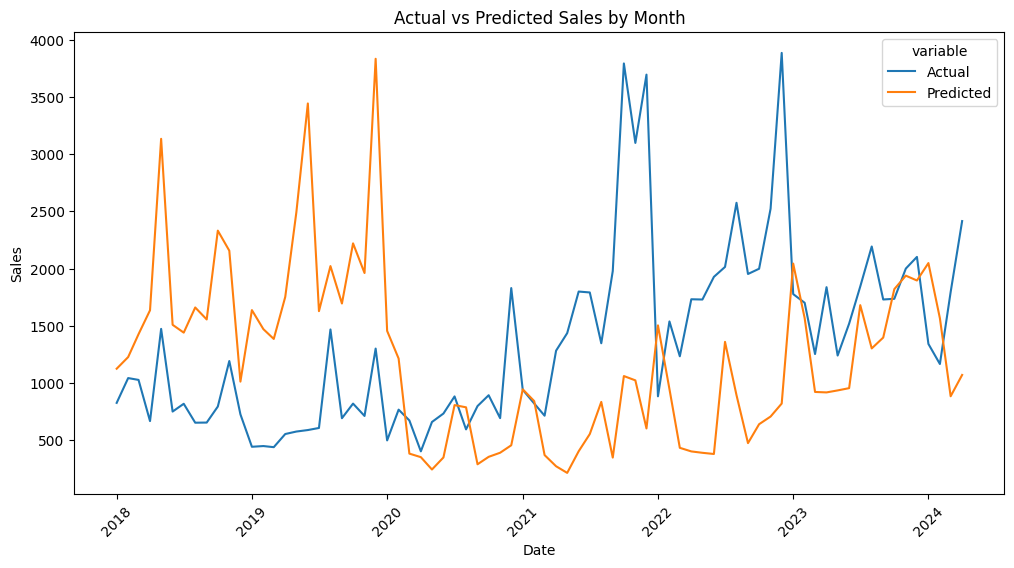

In [ ]:
plt.figure(figsize=(12, 6))
sns.lineplot(x='Date', y='value', hue='variable', data=pd.melt(result_by_month, ['Date'], value_vars=['Actual', 'Predicted']))
plt.xlabel('Date')
plt.ylabel('Sales')
plt.title('Actual vs Predicted Sales by Month')
plt.xticks(rotation=45)
plt.show()

In [ ]:
from sklearn.metrics import mean_absolute_percentage_error


In [ ]:
y_pred = model.predict(X_test)

In [ ]:
mape = mean_absolute_percentage_error(y_test, y_pred)
print(f"Mean Absolute Percentage Error (MAPE): {mape:.2%}")

Mean Absolute Percentage Error (MAPE): 988365957923783808.00%


In [ ]:
from sklearn.metrics import r2_score

In [ ]:
y_pred = model.predict(X_test)

In [ ]:
r2 = r2_score(y_test, y_pred)
print(f"R-squared: {r2:.4f}")

R-squared: -0.0518


In [ ]:
result['Date'] = pd.to_datetime(result['YEAR'].astype(str) + '-' + result['MONTH'].astype(str) + '-' + result['DAY'].astype(str), format='%Y-%m-%d')

In [ ]:
groups = result.groupby('PTNR_RM_CODE')


In [ ]:
num_groups = len(groups)
num_rows = (num_groups + 2) // 3  
num_cols = 3 

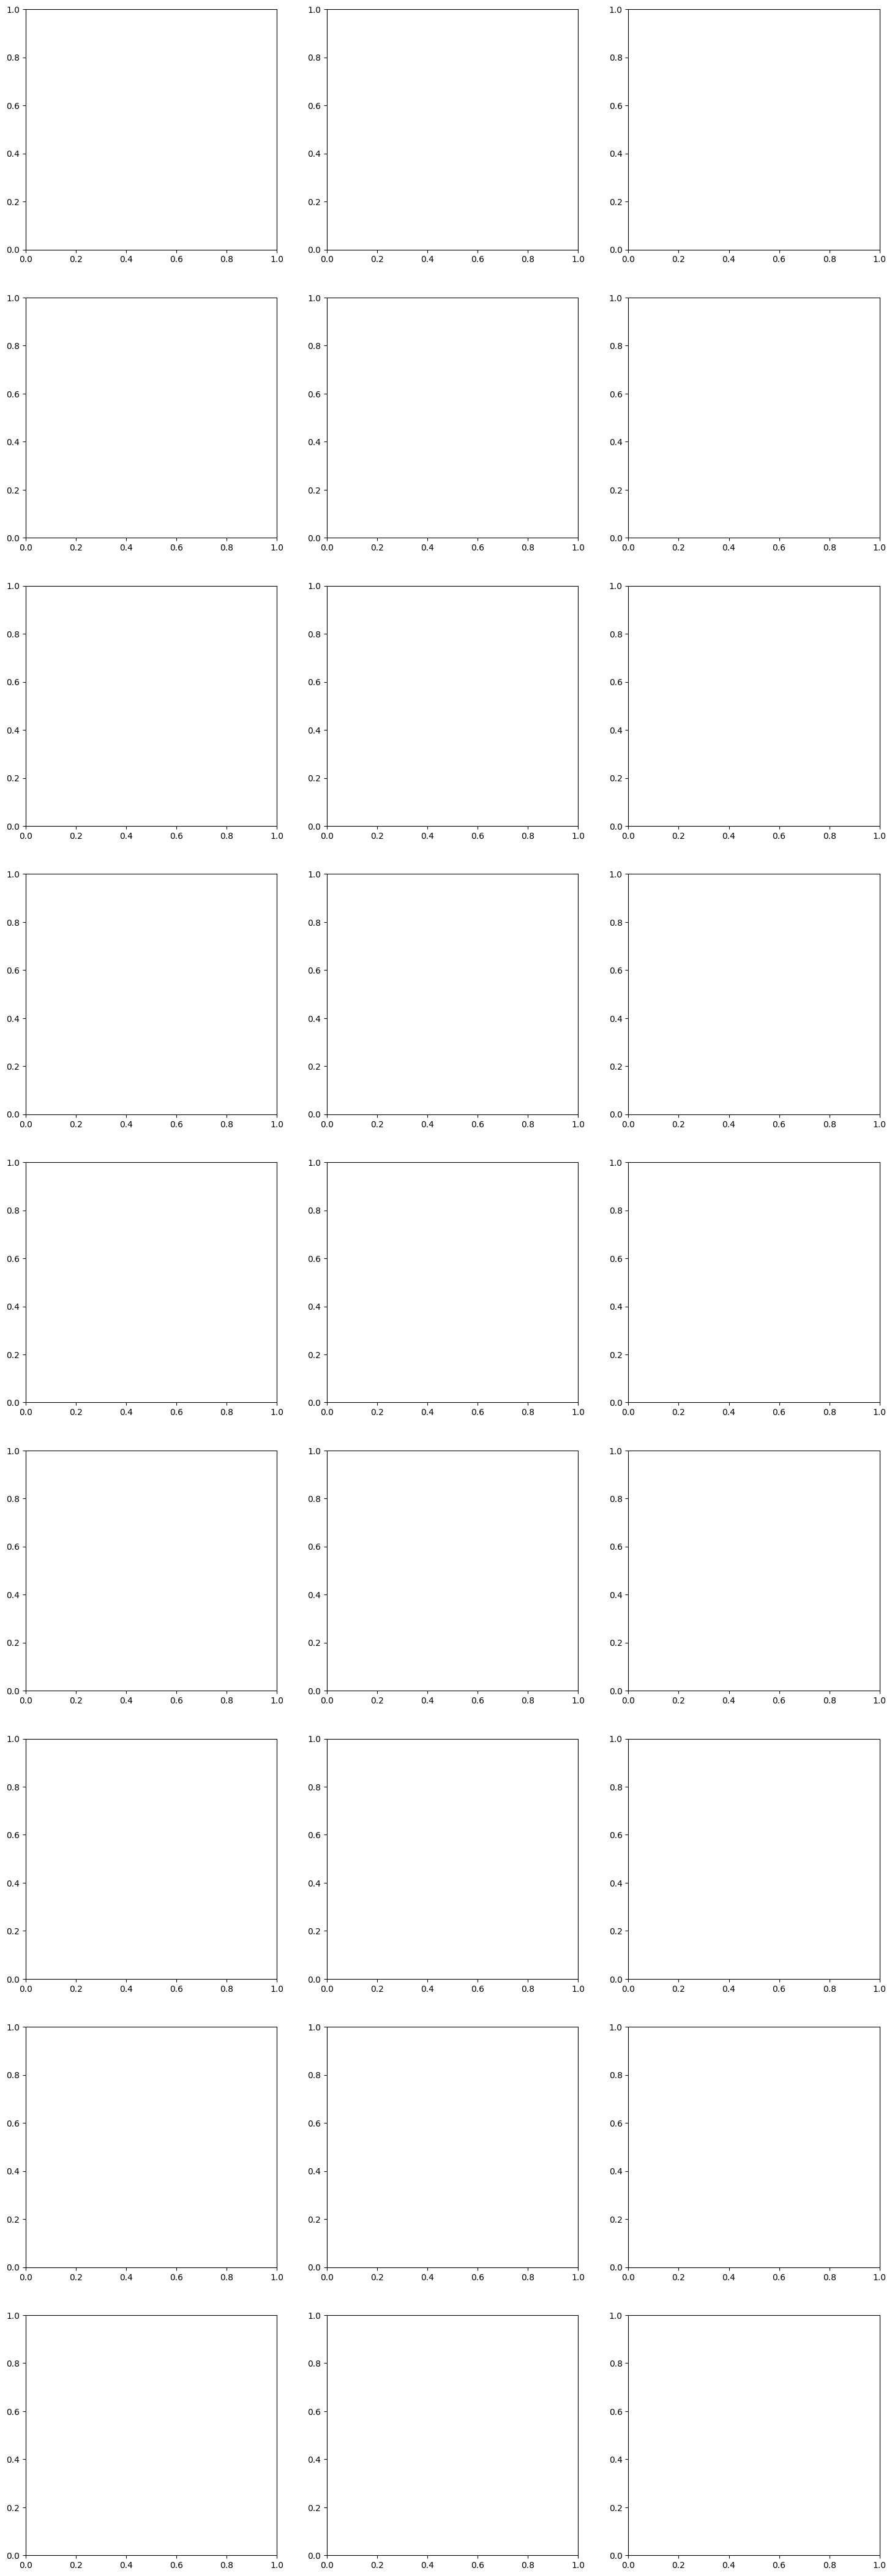

In [ ]:
fig, axes = plt.subplots(num_rows, num_cols, figsize=(18, 6 * num_rows))
axes = axes.flatten()

In [ ]:
for i, (group_name, group_data) in enumerate(groups):
    if i >= len(axes):
        break  

    ax = axes[i]
    group_data = group_data.sort_values('Date')  # Sort the data by date
    sns.lineplot(x='Date', y='Actual', data=group_data, label='Actual', ax=ax)
    sns.lineplot(x='Date', y='Predicted', data=group_data, label='Predicted', ax=ax)
    ax.set_title(f'PTNR_RM_CODE: {group_name}')
    ax.set_xlabel('Date')
    ax.set_ylabel('Sales')
    ax.legend()

    # Rotate the x-axis labels for better readability
    plt.sca(ax)
    plt.xticks(rotation=45)


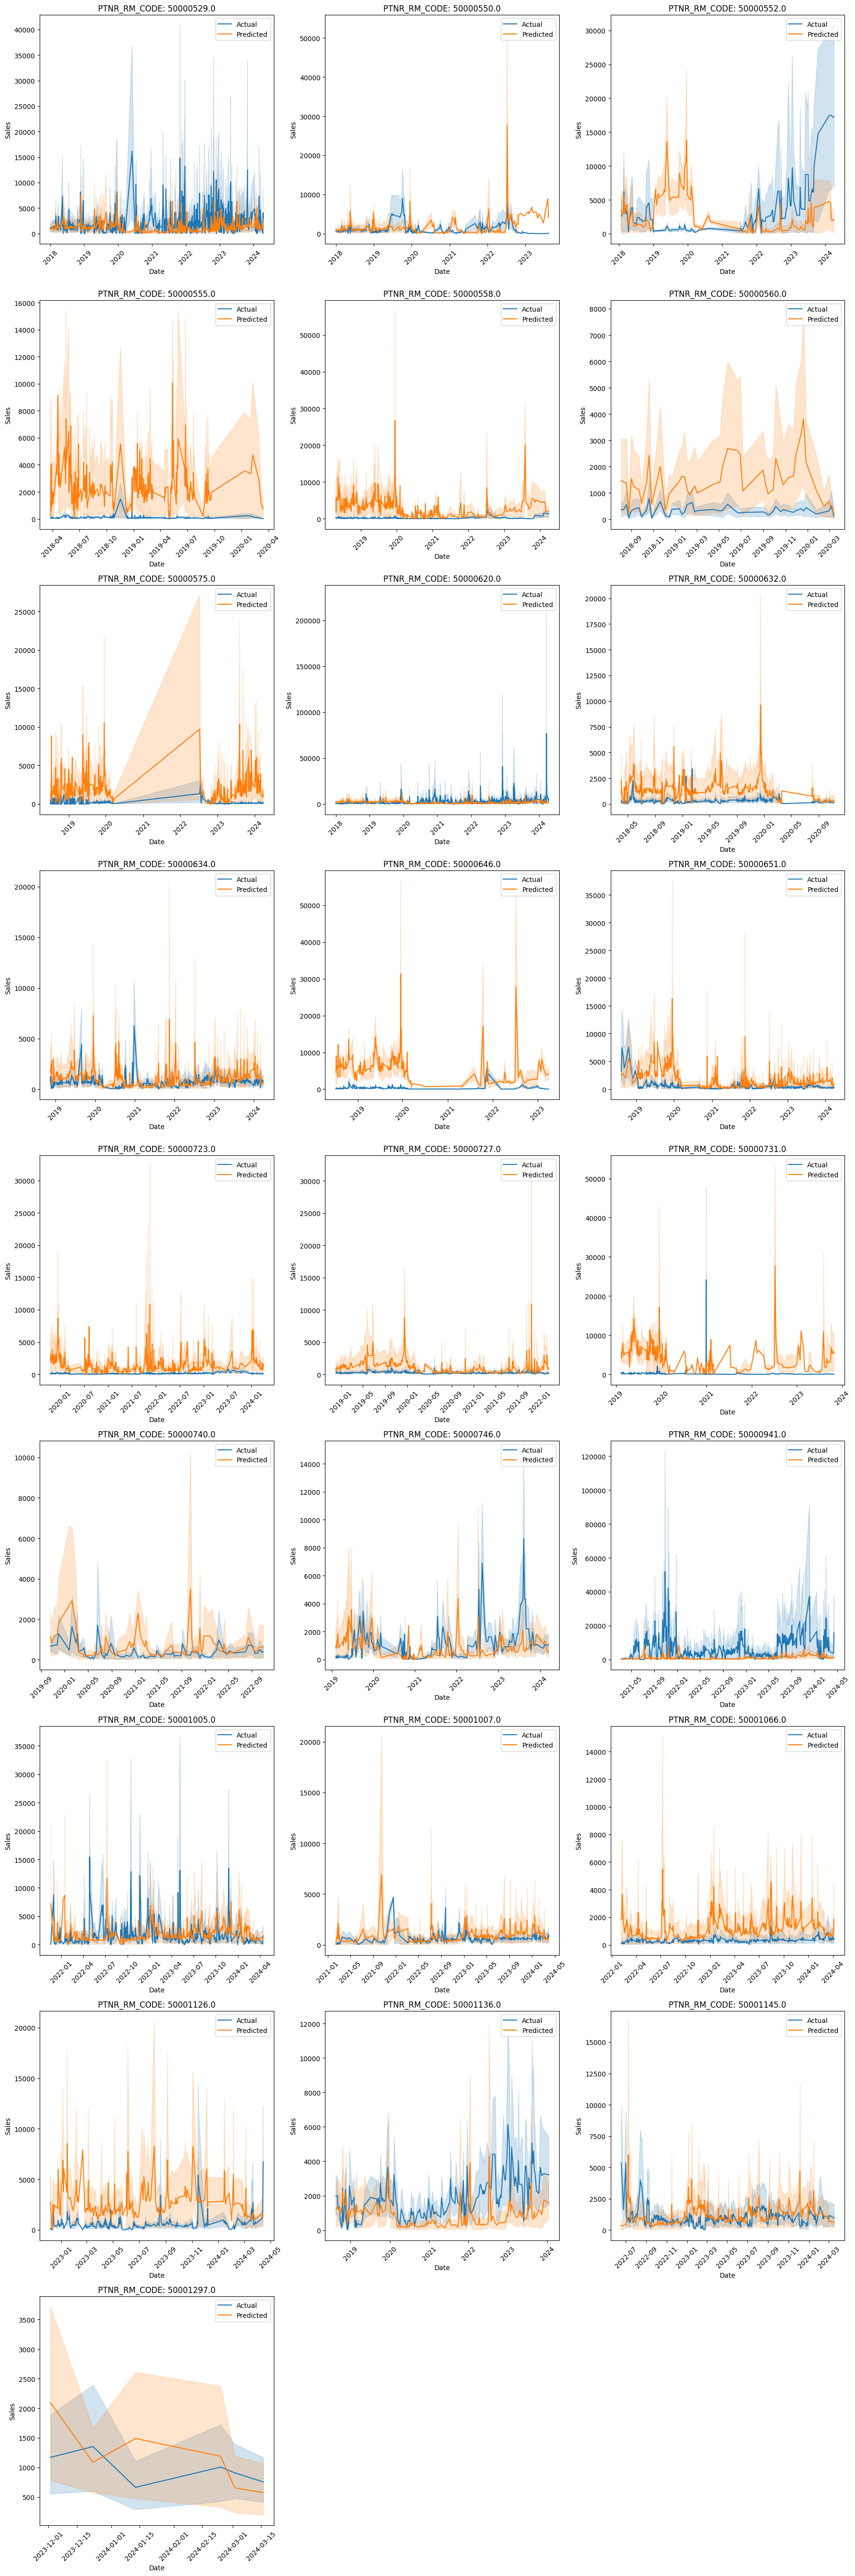

In [ ]:
for j in range(i + 1, len(axes)):
    axes[j].axis('off')

plt.tight_layout()
plt.show()